## Title :
Transfer Learning

## Description :
The goal of this exercise is to use Transfer Learning to achieve near-perfect accuracy for a highly customized task. The task at hand is to distinguish images of people with Sun Glasses or Hat. 

<img src="../fig/fig1.png" style="width: 500px;">

## Instructions :

- Use the helper code to get the image data.
- Use the `ImageDataGenerator` function to process the image data with a validation_split of 0.2.
- Create a train and validation generator with `flow_from_directory`.
- Ensure that the processed input images are correctly split into the train and validation sets using `flow_from_directory`. 
- Use the Keras Functional API to call the MobileNet architecture with imagenet weights.
- Add an appropriate number of dense layers to the top of the called architecture.
- The output layers consists of 2 nodes with `softmax` activation.
- Take a quick look at the summary to understand your model architecture.
- Freeze the first 10 layers to ensure it does not train and make the remaining layers trainable.
- Compile the model and fit on the train and validation data.
- Take a look at how your model performs by predicting on unseen images using the helper code.

<img src="../fig/fig2.png" style="width: 500px;">

## Hints :

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator" target="_blank">tf.keras.ImageDataGenerator()</a> Generate batches of tensor image data with real-time data augmentation.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator" target="_blank">ImageDataGenerator.flow_from_directory()</a> Takes the path to a directory & generates batches of augmented data.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNet" target="_blank">tf.keras.applications.MobileNet()</a> Instantiates the MobileNet architecture.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense" target="_blank">tf.keras.layers.Dense()</a> Returns a regular densely-connected NN layer.

<a href="https://keras.io/api/models/model/#model-class" target="_blank">keras.Model()</a> Model groups layers into an object with training and inference features.

<a href="https://www.tensorflow.org/js/guide/models_and_layers#model_summary" target="_blank">model.summary()</a> Print a useful summary of the model.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile" target="_blank">model.compile()</a> Configures the model for training.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit" target="_blank">model.fit()</a> Trains the model for a fixed number of epochs (iterations on a dataset).

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer" target="_blank">layer.trainable()</a> To set layers to trainable.

<a href="https://colab.research.google.com/drive/1kGoHKlYNZ1bbltYD8YFEP8qXmd2F7Eu3?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

  **(Note: This notebook will not run on Ed. Please click the button above to run in Google Colab)**

In [2]:
# Importing necessary packages and libraries

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import os
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


2023-07-23 23:36:08.723741: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 23:36:08.750056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 23:36:08.750734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 23:36:09.359871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# resized
!wget https://cs109b-course-data.s3.amazonaws.com/Lecture18/resized_lecture18.zip
!unzip -qq resized_lecture18.zip

/usr/bin/zsh: /home/ting/ENTER/envs/cs109a/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
--2023-07-23 23:36:10--  https://cs109b-course-data.s3.amazonaws.com/Lecture18/resized_lecture18.zip
Resolving cs109b-course-data.s3.amazonaws.com (cs109b-course-data.s3.amazonaws.com)... 3.5.28.181, 52.217.192.225, 3.5.27.168, ...
Connecting to cs109b-course-data.s3.amazonaws.com (cs109b-course-data.s3.amazonaws.com)|3.5.28.181|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-07-23 23:36:10 ERROR 403: Forbidden.

/usr/bin/zsh: /home/ting/ENTER/envs/cs109a/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
unzip:  cannot find or open resized_lecture18.zip, resized_lecture18.zip.zip or resized_lecture18.zip.ZIP.


In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# returns Path to the downloaded file.
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
# It creates a new path that points to a directory named 'cats_and_dogs_filtered' located in the same parent directory as the specified path_to_zip variable.
# os.path.dirname() extracts the directory name from a given path.
print(path_to_zip)
PATH

/home/ting/.keras/datasets/cats_and_dogs.zip


'/home/ting/.keras/datasets/cats_and_dogs_filtered'

In [21]:
validation_dir 

'/home/ting/.keras/datasets/cats_and_dogs_filtered/validation'

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')


In [6]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [7]:
DATA_DIR = '.'
# assigns the current directory (denoted by .) to the variable DATA_DIR

### ⏸ If you were to build a custom classifier using Transfer Learning, which pre-trained model would you use:
**(Please answer this in quiz)**

#### A. VGG16 model trained on medical images
#### B. MobileNet model trained on ImageNet
#### C. InceptionNet model trained on Landscape images

In [8]:
### edTest(test_chow1) ###
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer1 = '___'

## Get dataset

In [9]:
### edTest(test_split) ###

# Path of image data
# data_path = os.path.join(DATA_DIR, 'images/train')
# data_path = os.path.join(DATA_DIR, 'resized_lecture18/train')


# Use the `ImageDataGenerator` function from keras to generate new images based on our existing ones
# Mention the preprocessing function as mobilenet's preprocess_input and specify a validation split of 20%
train_datagen=ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.2) 

# Build your train_generator by specifying the directory using the data_path variable defined above
# Mention target size, color mode, batch_size, subset as 'train' and shuffle = True
train_generator=train_datagen.flow_from_directory(directory = train_dir, subset = "training", shuffle=True, batch_size=BATCH_SIZE, target_size=IMG_SIZE)

# Build your validation_generator similar to the previous step 
# Specifying using the data_path variable defined above with subset as 'validation'
validation_generator=train_datagen.flow_from_directory(directory=train_dir, subset = "validation", shuffle=True, batch_size=BATCH_SIZE, target_size=IMG_SIZE)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


## Mobilenet plug and play

Lets now use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers. Note only two classifiers.

In [10]:
# Use the mobilenet architecture as a starting point for our base model 

# Import the mobilenet model with pre-trained imagenet weights
# Discard the last 1000 neuron layer ie. the final fully connected layer
base_model=MobileNet(weights = "imagenet", include_top=False) 
# include_top, whether to include the fully-connected layer at the top of the network. Defaults to True. 
base_model.summary()
# some parameters remain fixed and will not be updated during training.
# Typically, these are parameters that are specific to the model architecture and not learned from data. For example, batch normalization statistics...

2023-07-23 23:36:11.763857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 23:36:11.787663: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 

In [11]:

x=base_model.output

x=GlobalAveragePooling2D()(x)
# layers are usually represented as callable objects or functions. 
# When you create a layer instance, you can call it as a function to apply the layer's operation to a specific input tensor. 
# GlobalAveragePooling2D(): This part creates an instance 
# (x) indicate that we are calling the GlobalAveragePooling2D layer with x as its input.

# On top of mobile net, add a few dense layers with 'relu' activation

# Using functional API, add a dense layer with 1024 neurons 
x=Dense(1024)(x)

# Add a dense layer with 512 neurons
x=Dense(512)(x)

# Add a final layer with 2 neurons and softmax activation 
preds=Dense(2, activation = "softmax")(x) 

In [12]:
# Using the functional API of keras, specify the input from the base model and the output as `preds` described above

model1=Model(inputs = base_model.input, outputs = preds) #specify the inputs and outputs
# Model() can include multiple layers, preds remembers the achitecture of layers


### ⏸ When you used the pre-trained model in the exercise, did you use the entire pre-trained model (convolution layers and classification dense layers) with all the layers?
**(Please answer this in quiz)**

#### A. True
#### B. False

In [13]:
### edTest(test_chow2) ###
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer2 = 'B'

We will use pre-trained weights as the model has been trained already on the Imagenet dataset. We ensure all the weights are non-trainable. We will only train the last few dense layers.

In [14]:
### edTest(test_layers) ###
# For transfer learning, we need to freeze some layers. Below we freeze the first 10 layers

# Freeze the first 10 layers of the network to be non-trainable
for layer in model1.layers[:10]:
    layer.trainable = False
    

Lets check the model architecture

In [15]:
### edTest(test_summary) ###
# Look at the summary of your model
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128   

### ⏸ In the pre trained model from the exercise how many trainable params did you have?

**(Please answer this in quiz)**

In [16]:
### edTest(test_chow3) ###
# Submit an answer as 10,000 or 10000
answer3 = '___'

Now lets load the training data into the ImageDataGenerator. Specify path, and it automatically sends the data for training in batches, simplifying the code.

Compile the model. Now lets train it. Should take less than two minutes on a GTX1070 GPU.

## Training the model

In [17]:
# We now train our model, but first we will compile it with an appropriate loss function and optimizer

# Adam optimizer
# loss function will be categorical crossentropy
# evaluation metric will be accuracy

model1.compile(metrics = ["accuracy"], loss= "categorical_crossentropy", optimizer="Adam")



In [18]:
type(model1)

keras.src.engine.functional.Functional

In [19]:
# Fit the model using the step size for train and validation specified below
# Given the limited resources, please restrict the number of epochs to less than 5

step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=validation_generator.n//validation_generator.batch_size

model1.fit(x = train_generator, validation_data = validation_generator, steps_per_epoch=step_size_train, validation_steps=step_size_validation, epochs=5)

Epoch 1/5


2023-07-23 23:36:17.986306: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-07-23 23:36:18.006526: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-07-23 23:36:18.012423: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-07-23 23:36:18.020803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52428800 exceeds 10% of free system memory.
2023-07-23 23:36:18.030856: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53747712 exceeds 10% of free system memory.


50/50 [==============================] - 33s 594ms/step - loss: 1.4154 - accuracy: 0.8575 - val_loss: 25.4923 - val_accuracy: 0.5469
Epoch 2/5
50/50 [==============================] - 29s 586ms/step - loss: 0.1947 - accuracy: 0.9325 - val_loss: 1.4043 - val_accuracy: 0.9167
Epoch 3/5
50/50 [==============================] - 31s 618ms/step - loss: 0.0494 - accuracy: 0.9819 - val_loss: 0.3046 - val_accuracy: 0.9583
Epoch 4/5
50/50 [==============================] - 29s 578ms/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.3865 - val_accuracy: 0.9531
Epoch 5/5
50/50 [==============================] - 29s 585ms/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.2510 - val_accuracy: 0.9557


Model is now trained. Now lets test some independent input images to check the predictions.

## Inference on unseen data

In [20]:
# A helper function that takes a standard image and converts it into a tensor that can be used by the model

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    # !!!!! load image
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor = preprocess_input(img_tensor)               # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [22]:
# # We specify the paths of the six images 

# We specify the paths of the six images 
#31.jpg	458.jpg  571.jpg  667.jpg  672.jpg
# First set of images
img_path1 = os.path.join(validation_dir, 'cats/cat.2000.jpg')
img_path2 = os.path.join(validation_dir, 'cats/cat.2088.jpg')
img_path3 = os.path.join(validation_dir, 'cats/cat.2411.jpg')


# Second set of images
img_path4 = os.path.join(validation_dir, 'dogs/dog.2034.jpg')
img_path5 = os.path.join(validation_dir, 'dogs/dog.2293.jpg')
img_path6 = os.path.join(validation_dir, 'dogs/dog.2134.jpg')


In [26]:
train_generator.class_indices.items()

dict_items([('cats', 0), ('dogs', 1)])

In [38]:
new_image = load_image(img_path1)
model1.predict(new_image)

1/1 [==============================] - 0s 20ms/step


array([[1.0000000e+00, 1.6230162e-17]], dtype=float32)

In [37]:
# Helper function that nicely predicts the class along with the input image

def prediction(img_loc,ax):
    new_image = load_image(img_loc)
    pred = model1.predict(new_image)
    classmap = {v:k for k,v in (train_generator.class_indices).items()}
    plot_img = mpimg.imread(img_loc);
    ax.imshow(plot_img, vmin=0, vmax=255)
    ax.set_title(f'Prediction: {classmap[pred.argmax(-1)[0]]} \n (with confidence: {str(pred[0][pred.argmax(-1)][0])[:4]})'  ,fontsize=18)
    # argmax(-1) means that the function is applied along the last axis of the prediction output array.
    ax.axis('off')

1/1 [==============================] - 0s 22ms/step


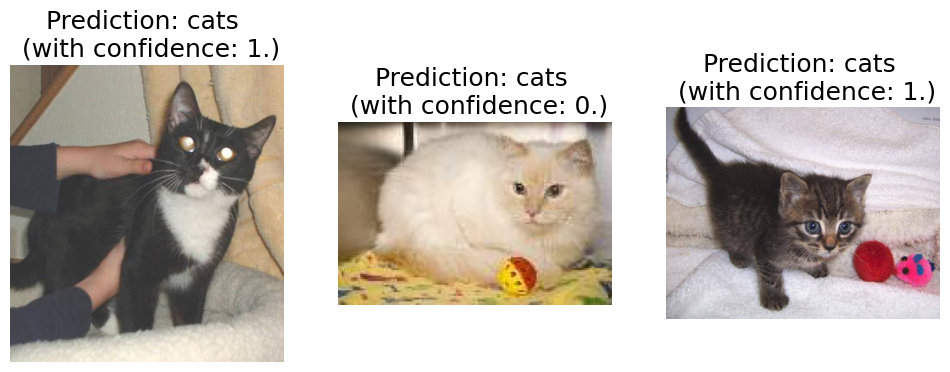

In [36]:
# Make predictions on first set of images defined above that were never shown to the model before
fig, axes = plt.subplots(1,3,figsize=(12,6))

# For each prediction mention the axes
prediction(img_path1, axes[0])
prediction(img_path2, axes[1])
prediction(img_path3, axes[2])

1/1 [==============================] - 0s 21ms/step


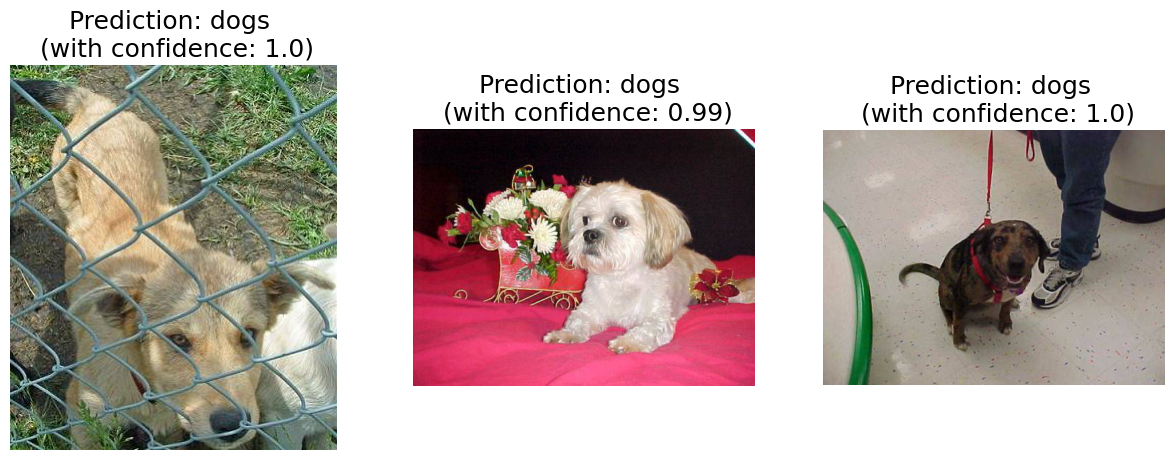

In [30]:
# Make predictions on second set of images defined above that were never shown to the model before
fig, axes = plt.subplots(1,3,figsize=(15,5))

# # Call the prediction function defined above for this
# # For each prediction mention the axes
# ___
# ___
# ___

# For each prediction mention the axes
# For each prediction mention the axes
prediction(img_path4, axes[0])
prediction(img_path5, axes[1])
prediction(img_path6, axes[2])

# Mindchow 🍲

Go back and change the number of trainable parameters. How does it affect your network performance?

*Your answer here*